# MPT(Modern Portfolio Tehory) based Backtesting trading strategies
* ref : https://github.com/bottama/trading-strategy-backtest/blob/main/src/risk_parity_portfolio.py

# 벡테스트 전략

* 평균분산 : The Optimal Markowitz Portfolio
* 최소분산 : The Global Minimum Variance Portfolio : 최소 편차
* 리스크패리디 : The Risk-Parity Portfolio : 리스크
* 균등 가중치 : The Equally Weighted Portfolio

# 관련 ETF
* EEM: iShares MSCI Emerging Markets ETF
* EMLC: VanEck Vectors J.P. Morgan EM Local Currency Bond ETF
* IAU: iShares Gold Trust
* IEF: iShares 7-10 Year Treasury Bond ETF
* IWM: iShares Russell 2000 ETF
* SPY: SPDR S&P 500 ETF Trust
* TIP: iShares TIPS Bond ETF
* TLT: iShares 20+ Year Treasury Bond ETF
* VGK: Vanguard FTSE Europe Index Fund ETF Shares

<pre>
trading-strategy-backtest/
    deliverable/
        run_backtest.py
    src/
        equally_weighted_portfolio.py
        mean_variance_portfolio.py
        minimum_variance_portfolio.py
        risk_parity_portoflio.py
    README.md

## Equally weighted Portfolio

In [2]:

def equally_weighted_portfolio(ret):
    init_weights = [1 / len(ret.columns)] * len(ret.columns)
    opt_weights = init_weights

    return opt_weights


# risk_parity_portfolio

In [4]:
def risk_parity_portfolio(ret):
    init_guess = 1 / ret.std()
    opt_weights = list(init_guess / init_guess.sum())

    return opt_weights

# minimum_variance_portfolio

In [5]:
import numpy as np
from scipy.optimize import minimize


def minimum_variance_portfolio(ret):

    # define objective function to minimize: variance
    def get_portfolio_variance(weights):
        weights = np.array(weights)  # check
        cov_mat = ret.cov()
        port_variance = np.dot(weights.T, np.dot(cov_mat, weights))
        return port_variance

    # equality constraint: sum of the weights = 1
    def weight_cons(weights):
        return np.sum(weights) - 1

    # model set-up
    # - long only portfolio
    # - initial guess
    # - constraints
    bounds_lim = ((0, 1),) * len(ret.columns)
    init_weights = [1 / len(ret.columns)] * len(ret.columns)
    constraint = {'type': 'eq', 'fun': weight_cons}

    # find optimal portfolio
    opt_port = minimize(fun=get_portfolio_variance,
                        x0=init_weights,
                        bounds=bounds_lim,
                        constraints=constraint,
                        method='SLSQP')

    # find optimal weights
    opt_weights = list(opt_port['x'])

    return opt_weights

# mean_variance_portfolio

In [6]:
# import modules
import numpy as np
from scipy.optimize import minimize


def mean_variance_portfolio(ret):

    # define objective function to minimize: sharpe ratio
    def get_portfolio_sr(weights):

        weights = np.array(weights)  # check

        # expected returns
        port_ret = np.dot(ret, weights)
        mean_ret = port_ret.mean()

        # volatility
        cov_mat = ret.cov()
        port_std = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))

        # sharpe ratio
        port_sr = mean_ret / port_std
        return port_sr

    def objective_fun(weights):
        neg_sr = get_portfolio_sr(weights) * (-1)
        return neg_sr

    # equality constraint: sum of the weights = 1
    def weight_cons(weights):
        return np.sum(weights) - 1

    # model set-up
    # - long only portfolio
    # - initial guess
    # - constraints
    bounds_lim = ((0, 1),) * len(ret.columns)
    init_weights = [1 / len(ret.columns)] * len(ret.columns)
    constraint = {'type': 'eq', 'fun': weight_cons}

    # find optimal portfolio
    opt_port = minimize(fun=objective_fun,
                        x0=init_weights,
                        bounds=bounds_lim,
                        constraints=constraint,
                        method='SLSQP')

    # find optimal weights
    opt_weights = list(opt_port['x'])

    return opt_weights

# deliverable

In [11]:
# import modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
# main variables
tickers = ['SPY', 'EEM', 'TIP', 'IAU', 'IEF', 'TLT', 'VGK', 'IWM', 'EMLC']
months_training_set = 12 * 5
months_test_set = 1
initial_capital = 1

# data
prices = yf.download(tickers=tickers)['Adj Close']
prices = prices.dropna(axis=0)
daily_ret = np.log(prices / prices.shift(1))[1:]
monthly_ret = daily_ret.groupby(pd.Grouper(freq='M')).apply(np.sum)

# strategy back-test
index = list(prices.columns)
columns = [1] * (len(monthly_ret.index) - months_training_set)
portfolio_weights_df = pd.DataFrame(data=index, columns=['index'])
weights_equally_weighted = portfolio_weights_df
weights_risk_parity = portfolio_weights_df
weights_minimum_variance = portfolio_weights_df
weights_mean_variance = portfolio_weights_df

[*********************100%***********************]  9 of 9 completed



## monthly back-test with rolling approach

In [13]:
# initialize progress bar
pbar = tqdm(total=len(columns))
for i in range(len(columns)):
    # -- subset monthly returns -- #
    ret = monthly_ret.iloc[i:i + months_training_set, :]

    # -- find optimal portfolios -- #
    equally_weighted = pd.DataFrame(data=[index, equally_weighted_portfolio(ret)], index=['index', 'weight']).T
    risk_parity = pd.DataFrame(data=[index, risk_parity_portfolio(ret)], index=['index', 'weight']).T
    minimum_variance = pd.DataFrame(data=[index, minimum_variance_portfolio(ret)], index=['index', 'weight']).T
    mean_variance = pd.DataFrame(data=[index, mean_variance_portfolio(ret)], index=['index', 'weight']).T

    # -- append data to existing -- #
    weights_equally_weighted = pd.merge(weights_equally_weighted, equally_weighted, how='outer', on='index')
    weights_risk_parity = pd.merge(weights_risk_parity, risk_parity, how='outer', on='index')
    weights_minimum_variance = pd.merge(weights_minimum_variance, minimum_variance, how='outer', on='index')
    weights_mean_variance = pd.merge(weights_mean_variance, mean_variance, how='outer', on='index')

    # update progress bar
    pbar.update(1)
pbar.close()


  4%|██                                                      | 3/81 [00:00<00:08,  9.07it/s]C:\Users\677\AppData\Local\Temp/ipykernel_1640/1333171354.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'weight_x'} in the result is deprecated and will raise a MergeError in a future version.
  weights_equally_weighted = pd.merge(weights_equally_weighted, equally_weighted, how='outer', on='index')
C:\Users\677\AppData\Local\Temp/ipykernel_1640/1333171354.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'weight_x'} in the result is deprecated and will raise a MergeError in a future version.
  weights_risk_parity = pd.merge(weights_risk_parity, risk_parity, how='outer', on='index')
C:\Users\677\AppData\Local\Temp/ipykernel_1640/1333171354.py:16: FutureWarning: Passing 'suffixes' which cause duplicate columns {'weight_x'} in the result is deprecated and will raise a MergeError in a future version.
  weights_minimum_variance = pd.merge(weights_minimu

## get back-test results

In [14]:
def get_backtest_results(weights_df):

    # get final weights data-frames
    def get_final_weights(weights_df):
        weights_df = weights_df.set_index('index')
        weights_df = weights_df.T
        weights_df.index = daily_ret.resample('BMS').first().index[-len(weights_df):]
        return weights_df

    final_weights = get_final_weights(weights_df)

    # get buy and sell price
    open_prices = prices.resample('BMS').first()
    open_prices = open_prices[months_training_set:]
    close_prices = prices.resample('M').last()
    close_prices = close_prices[months_training_set:]

    # get cumulative returns
    def get_cumulative_returns(weights_df):

        # initialize data
        portfolio_cum_ret = []
        starting_capital = initial_capital

        pbar = tqdm(total=len(weights_df))

        # loop
        for i in range(len(weights_df)):
            # - n:                 number of share bought at the start of the month
            # - s:                 start date of the investment every month
            # - e:                 end date every of the investments every month
            # - p:                 portfolio value
            # - starting_capital:  set the starting capital of the next month as the last value of the previous month
            # - portfolio_cum_ret: append every portfolio value
            n = (weights_df.iloc[i, :] * starting_capital) / open_prices.iloc[i, :]
            s = open_prices.index[i]
            e = close_prices.index[i]
            p = np.sum(prices.loc[str(s):str(e)] * n, axis=1)
            starting_capital = p[-1]
            portfolio_cum_ret.append(list(p))

            # update progress bar
            pbar.update(1)

        # final results
        portfolio_cum_ret = [item for sublist in portfolio_cum_ret for item in sublist]
        pbar.close()

        return portfolio_cum_ret

    cumulative_returns = get_cumulative_returns(final_weights)

    # final data
    cumulative_returns = pd.DataFrame(data=cumulative_returns, index=prices[-len(cumulative_returns):].index)

    return cumulative_returns

In [15]:
backtest_equally_weighted = get_backtest_results(weights_equally_weighted)
backtest_risk_parity      = get_backtest_results(weights_risk_parity)
backtest_minimum_variance = get_backtest_results(weights_minimum_variance)
backtest_mean_variance    = get_backtest_results(weights_mean_variance)
backtest_df               = pd.DataFrame(data=[backtest_equally_weighted[0],
                                               backtest_risk_parity[0],
                                               backtest_minimum_variance[0],
                                               backtest_mean_variance[0]],
                                         index=['equally_weighted',
                                                'risk_parity',
                                                'minimum_variance',
                                                'mean_variance']).T

# sharpe ratio
mean_returns = (((backtest_df / backtest_df.shift(1))-1)[1:]).mean()
std_returns  = (((backtest_df / backtest_df.shift(1))-1)[1:]).std()
sharpe_ratio = mean_returns / std_returns

100%|██████████████████████████████████████████████████████| 81/81 [00:00<00:00, 295.01it/s]


## plot

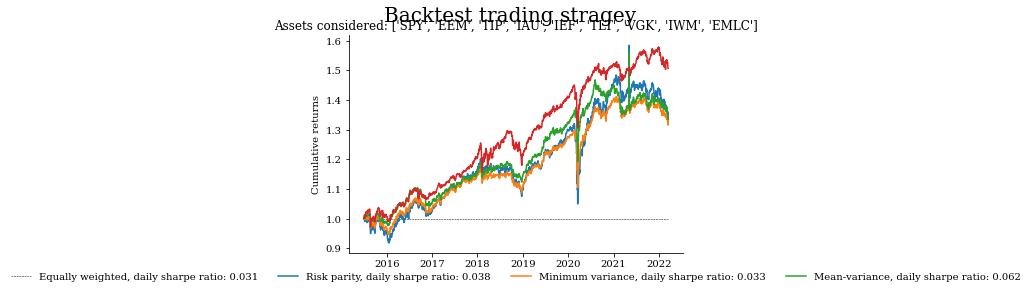

In [16]:
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Backtest trading stragey',fontsize=20)
plt.title('Assets considered: {}'.format(tickers))
plt.ylabel('Cumulative returns')
plt.hlines(y=initial_capital,
           linestyles='dashed',
           colors='black',
           xmin=backtest_df.index[0], xmax=backtest_df.index[-1], linewidth=0.5)
plt.plot(backtest_df)
plt.legend(['Equally weighted, daily sharpe ratio: ' + str(np.round(sharpe_ratio[0], 3)),
            'Risk parity, daily sharpe ratio: ' + str(np.round(sharpe_ratio[1], 3)),
            'Minimum variance, daily sharpe ratio: ' + str(np.round(sharpe_ratio[2], 3)),
            'Mean-variance, daily sharpe ratio: ' + str(np.round(sharpe_ratio[3], 3))],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)
plt.show()